In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<a name='1'></a>
# 1 - Libraries

In [ ]:
# for data load
import os

# for reading and processing images
import imageio
from PIL import Image

# for visualizations
import matplotlib.pyplot as plt

import numpy as np # for using np arrays

# for bulding and running deep learning model
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

In [ ]:
import math
import random
import numpy as np
import pandas as pd
import cv2
import skimage as ski
import os, sys
import matplotlib.pylab as plt

from tqdm import tqdm
from PIL import Image
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from skimage import feature
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio
from skimage.feature import local_binary_pattern # pip install scikit-image
#from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

<a name='2'></a>
# 2 - Helper Functions for Data Processing

<a name='2.1'></a>
## 2.1 - Load Data
* the masked images are stored as png, unmasked (original) as jpg
* the names of these 2 are same so for getting the right sample we can just sort the 2 lists

In [ ]:
def LoadData (path1, path2):
    """
    Looks for relevant filenames in the shared path
    Returns 2 lists for original and masked files respectively

    """
    # Read the images folder like a list
    image_dataset = os.listdir(path1)
    mask_dataset = os.listdir(path2)

    # Make a list for images and masks filenames
    orig_img = []
    mask_img = []
    for file in image_dataset:
        orig_img.append(file)
    for file in mask_dataset:
        mask_img.append(file)

    # Sort the lists to get both of them in same order (the dataset has exactly the same name for images and corresponding masks)
    orig_img.sort()
    mask_img.sort()

    return orig_img, mask_img

<a name='2.2'></a>
## 2.2 - Pre-Process Data

In [ ]:
def PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2):
    """
    Processes the images and mask present in the shared list and path
    Returns a NumPy dataset with images as 3-D arrays of desired size
    Please note the masks in this dataset have only one channel
    """
    # Pull the relevant dimensions for image and mask
    m = len(img)                     # number of images
    i_h,i_w,i_c = target_shape_img   # pull height, width, and channels of image
    m_h,m_w,m_c = target_shape_mask  # pull height, width, and channels of mask

    # Define X and Y as number of images along with shape of one image
    X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32)
    y = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)

    # Resize images and masks
    for file in img:
        # convert image into an array of desired shape (3 channels)
        index = img.index(file)
        path = os.path.join(path1, file)
        single_img = Image.open(path).convert('RGB')
        single_img = single_img.resize((i_h,i_w))
        single_img = np.reshape(single_img,(i_h,i_w,i_c))
        single_img = single_img/256.
        X[index] = single_img

        # convert mask into an array of desired shape (1 channel)
        single_mask_ind = mask[index]
        path = os.path.join(path2, single_mask_ind)
        single_mask = Image.open(path).convert('L') #convert to grey-scale image with 1 channel
        single_mask = single_mask.resize((m_h, m_w))
        single_mask = np.reshape(single_mask,(m_h,m_w,m_c))
        single_mask = single_mask - 1 # to ensure classes #s start from 0
        y[index] = single_mask
    return X, y

In [ ]:
def show_history(history, validation : bool = False):
    if validation:
        # Loss
        fig, axes = plt.subplots(figsize= (20,5))
        # Train
        axes.plot(history.epoch, history.history['loss'], color= 'r',  label = 'Train')
        axes.plot(history.epoch, history.history['val_loss'], color = 'b', label = 'Val')
        axes.set_xlabel('Epoch')
        axes.set_ylabel('Loss')
        axes.legend()
        # Acc
        fig, axes = plt.subplots(figsize= (20,5))
        # Train
        axes.plot(history.epoch, history.history['accuracy'], color= 'r',  label = 'Train')
        axes.plot(history.epoch, history.history['val_accuracy'], color = 'b', label = 'Val')
        axes.set_xlabel('Epoch')
        axes.set_ylabel('Acc')
        axes.legend()
        # Mean Iou
        fig, axes = plt.subplots(figsize= (20,5))
        # Train
        axes.plot(history.epoch, history.history['mean_iou'], color= 'r',  label = 'Train')
        axes.plot(history.epoch, history.history['val_mean_iou'], color = 'b', label = 'Val')
        axes.set_xlabel('Epoch')
        axes.set_ylabel('MeanIoU')
        axes.legend()
    else:
        fig, axes = plt.subplots(1,4, figsize= (20,5))
        # loss
        axes[0].plot(history.epoch, history.history['loss'])
        axes[0].set_title('Train')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        # Acc
        axes[1].plot(history.epoch, history.history['acc'])
        axes[1].set_title('Train')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Acc')
        # Mean Iou
        axes[2].plot(history.epoch, history.history['mean_iou'])
        axes[2].set_title('Train')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('MeanIoU')

<a name='3'></a>
#3 - Constructing the U-Net Architecture


<a name='3.1'></a>
## 3.1 - U-Net Encoder Block

In [ ]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning.
    Dropout can be added for regularization to prevent overfitting.
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow
    # Proper initialization prevents from the problem of exploding and vanishing gradients
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)

    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=True)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions
    skip_connection = conv

    return next_layer, skip_connection

<a name='3.2'></a>
## 3.2 - U-Net Decoder Block

In [ ]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same',
                 kernel_initializer='he_normal')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    #merge = concatenate([up, skip_layer_input], axis=3)
    merge = concatenate([up, skip_layer_input], axis=3)
    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters,
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    return conv

<a name='3.3'></a>
## 3.3 - Compile U-Net Blocks

In [ ]:
def UNetCompiled(input_size=(128, 128, 3), n_filters=32, n_classes=3):
  """
  Combine both encoder and decoder blocks according to the U-Net research paper
  Return the model as output
  """
  # Input size represent the size of 1 image (the size used for pre-processing)
  #inputs = input(input_size)
  inputs = tf.keras.layers.Input(input_size)

  # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
  # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image
  cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
  cblock2 = EncoderMiniBlock(cblock1[0], n_filters*2, dropout_prob=0, max_pooling=True)
  cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4, dropout_prob=0, max_pooling=True)
  cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8, dropout_prob=0.3, max_pooling=True)
  cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

  # Decoder includes multiple mini blocks with decreasing number of filters
  # Observe the skip connections from the encoder are given as input to the decoder
  # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
  ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
  ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
  ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
  ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

  # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
  # Followed by a 1x1 Conv layer to get the image to the desired size.
  # Observe the number of channels will be equal to number of output classes
  conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

  conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
  #dense_layer = Dense(units=1, activation='relu')(conv10)
  #flatten_layer = Flatten()(conv10)

  # Dense layer for classification
  #classification_output = Dense(8, activation='softmax')(flatten_layer)

  # Combined model
  #model = tf.keras.Model(inputs=inputs, outputs=classification_output)
  model = tf.keras.Model(inputs=inputs, outputs=conv10)

  return model

[văn bản liên kết](https://)<a name='4'></a>
# 4 - Executing above Functions to Train the Model

<a name='4.1'></a>
## 4.1 - Load and View Data

<ipython-input-8-ba6f20b525e6>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_view  = imageio.imread(path1 + img[i])
<ipython-input-8-ba6f20b525e6>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask_view = imageio.imread(path2 + mask[i])


(537, 959, 3)
(537, 959, 3)
(542, 483, 3)
(542, 483, 3)
(531, 958, 3)
(531, 958, 3)
(532, 959, 3)
(532, 959, 3)
(530, 480, 3)
(530, 480, 3)


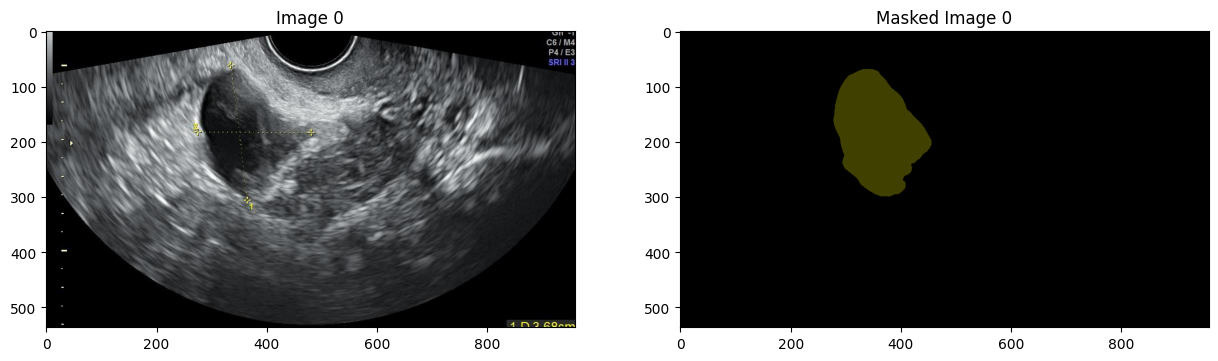

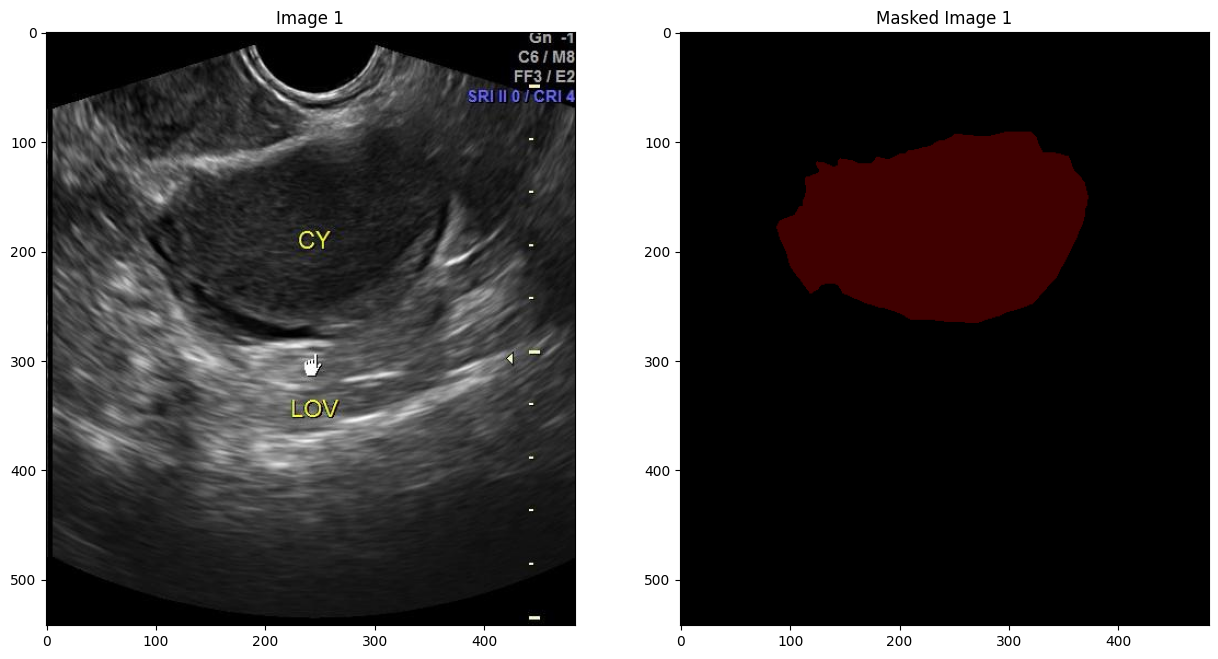

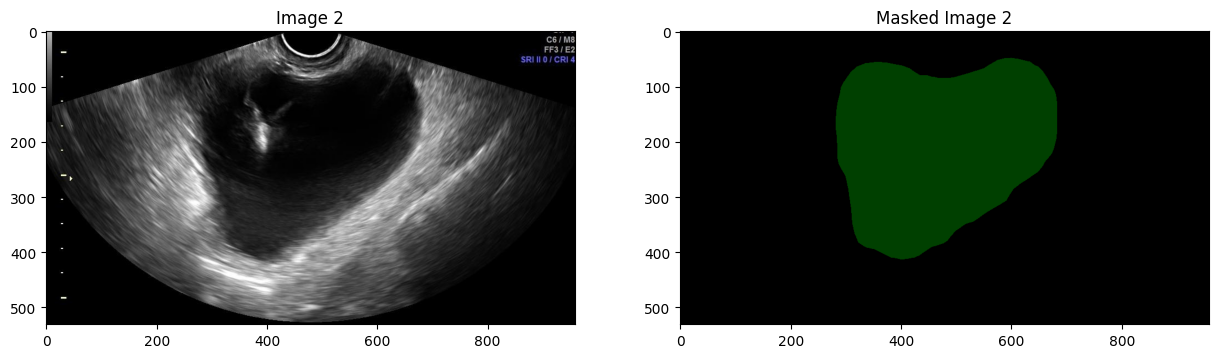

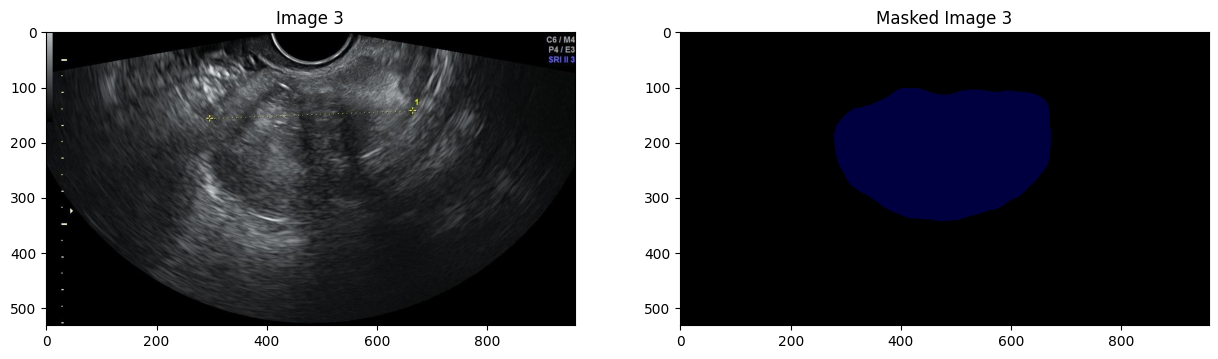

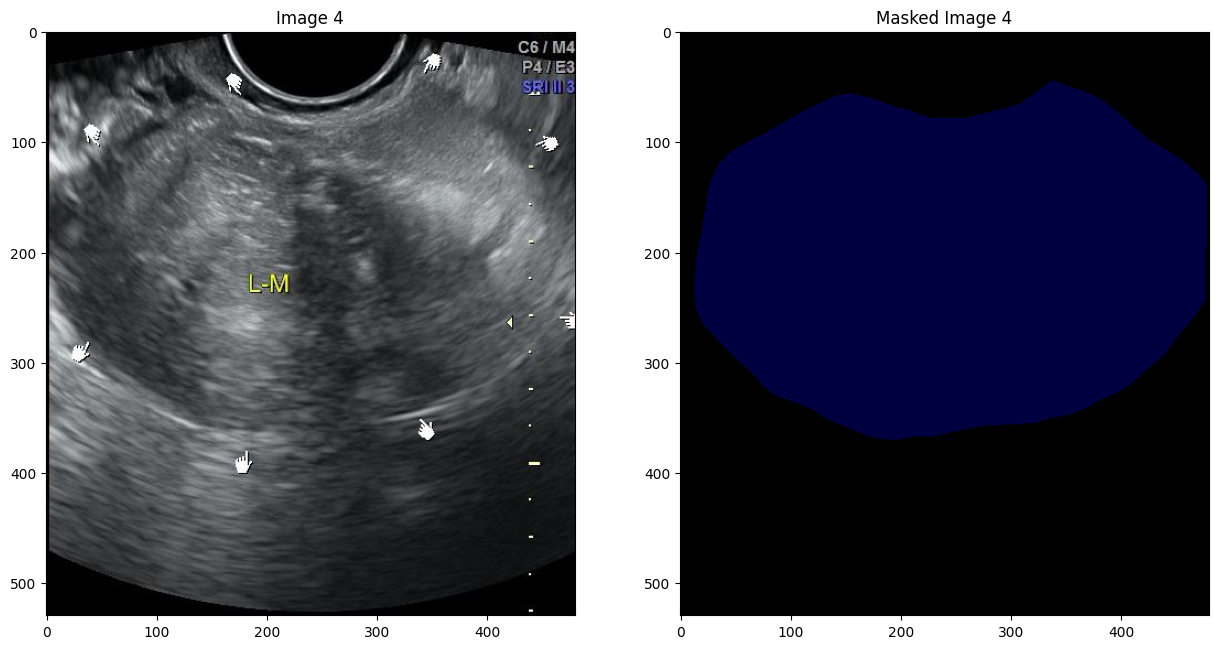

In [ ]:
""" Load Train Set and view some examples """
# Call the apt function
path1 = '/content/drive/MyDrive/Colab Notebooks/UTBT/OTU2d/images/'
path2 = '/content/drive/MyDrive/Colab Notebooks/UTBT/OTU2d/annotations/'
img, mask = LoadData (path1, path2)

# View an example of image and corresponding mask
show_images = 5
for i in range(show_images):
    img_view  = imageio.imread(path1 + img[i])
    mask_view = imageio.imread(path2 + mask[i])
    print(img_view.shape)
    print(mask_view.shape)
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(img_view)
    arr[0].set_title('Image '+ str(i))
    arr[1].imshow(mask_view)
    arr[1].set_title('Masked Image '+ str(i))

<a name='4.2'></a>
## 4.2 - Process Data

X Shape: (1469, 128, 128, 3)
Y shape: (1469, 128, 128, 1)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81 255]


Text(0.5, 1.0, 'Processed Masked Image ')

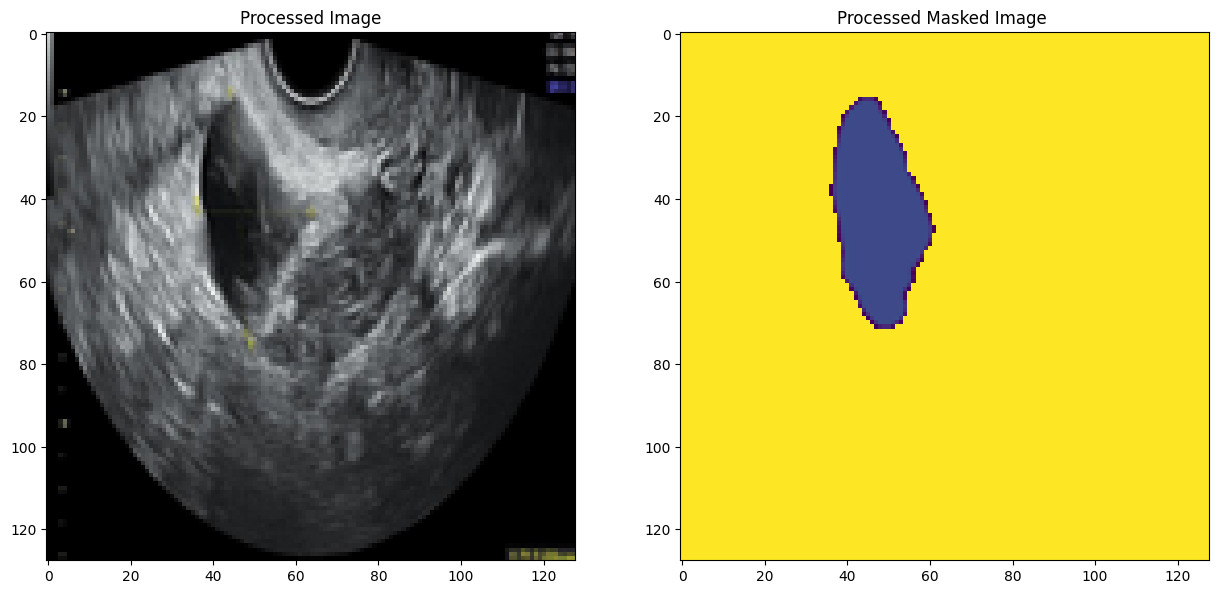

In [ ]:
# Define the desired shape
target_shape_img = [128, 128, 3]
target_shape_mask = [128, 128, 1]

# Process data using apt helper function
X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2)

# QC the shape of output and classes in output dataset
print("X Shape:", X.shape)
print("Y shape:", y.shape)
# There are 3 classes : background, pet, outline
print(np.unique(y))

# Visualize the output
image_index = 0
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(X[image_index])
arr[0].set_title('Processed Image')
arr[1].imshow(y[image_index,:,:,0])
arr[1].set_title('Processed Masked Image ')

## 4.3 - Split Train and Test Set

In [ ]:
# Use scikit-learn's function to split the dataset
# Here, I have used 20% data as test/valid set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)

<a name='4.4'></a>
## 4.4 - Build U-Net Architecture

In [ ]:
# Call the helper function for defining the layers for the model, given the input image size
unet = UNetCompiled(input_size=(128,128,3), n_filters=32, n_classes=256)

In [ ]:
# Check the summary to better interpret how the output dimensions change in each layer
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         128       ['conv2d_1[0][0]']            
 Normalization)                                                                               

In [ ]:
class m_iou():
    def __init__(self, classes: int) -> None:
        self.classes = classes
    def mean_iou(self,y_true, y_pred):
        y_pred = np.argmax(y_pred, axis = 3)
        miou_keras = MeanIoU(num_classes= self.classes)
        miou_keras.update_state(y_true, y_pred)
        return miou_keras.result().numpy()
    def miou_class(self, y_true, y_pred):
        y_pred = np.argmax(y_pred, axis = 3)
        miou_keras = MeanIoU(num_classes= self.classes)
        miou_keras.update_state(y_true, y_pred)
        values = np.array(miou_keras.get_weights()).reshape(self.classes, self.classes)
        for i in  range(self.classes):
            class_iou = values[i,i] / (sum(values[i,:]) + sum(values[:,i]) - values[i,i])
            print(f'IoU for class{str(i + 1)} is: {class_iou}')

In [ ]:
m = m_iou(2)

<a name='4.5'></a>
## 4.5 - Compile and Run Model

In [ ]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint
filepath="/content/drive/MyDrive/Colab Notebooks/UTBT/OTU2d/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor= 'val_mean_iou', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# Run the model in a mini-batch fashion and compute the progress for each epoch
results = unet.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_valid, y_valid), callbacks=callbacks_list)

Epoch 1/5
37/37 [==============================] - ETA: 0s - loss: 1.7356 - accuracy: 0.7210 
Epoch 1: val_loss improved from -inf to 0.66626, saving model to /content/drive/MyDrive/Colab Notebooks/UTBT/OTU2d/weights-improvement-01-0.67.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/37 [==============================] - 918s 25s/step - loss: 1.7356 - accuracy: 0.7210 - val_loss: 0.6663 - val_accuracy: 0.8623
Epoch 2/5
37/37 [==============================] - ETA: 0s - loss: 0.6162 - accuracy: 0.8495 
Epoch 2: val_loss did not improve from 0.66626
37/37 [==============================] - 925s 25s/step - loss: 0.6162 - accuracy: 0.8495 - val_loss: 0.5238 - val_accuracy: 0.8732
Epoch 3/5
37/37 [==============================] - ETA: 0s - loss: 0.5281 - accuracy: 0.8648 
Epoch 3: val_loss did not improve from 0.66626
37/37 [==============================] - 894s 24s/step - loss: 0.5281 - accuracy: 0.8648 - val_loss: 0.4836 - val_accuracy: 0.8796
Epoch 4/5
37/37 [==============================] - ETA: 0s - loss: 0.4979 - accuracy: 0.8715 
Epoch 4: val_loss did not improve from 0.66626
37/37 [==============================] - 901s 24s/step - loss: 0.4979 - accuracy: 0.8715 - val_loss: 0.4830 - val_accuracy: 0.8851
Epoch 5/5
37/37 [==============================] - ET

<a name='5'></a>
# 5 - Evaluate Model Results

<a name='5.1'></a>
## 5.1 - Bias Variance Check

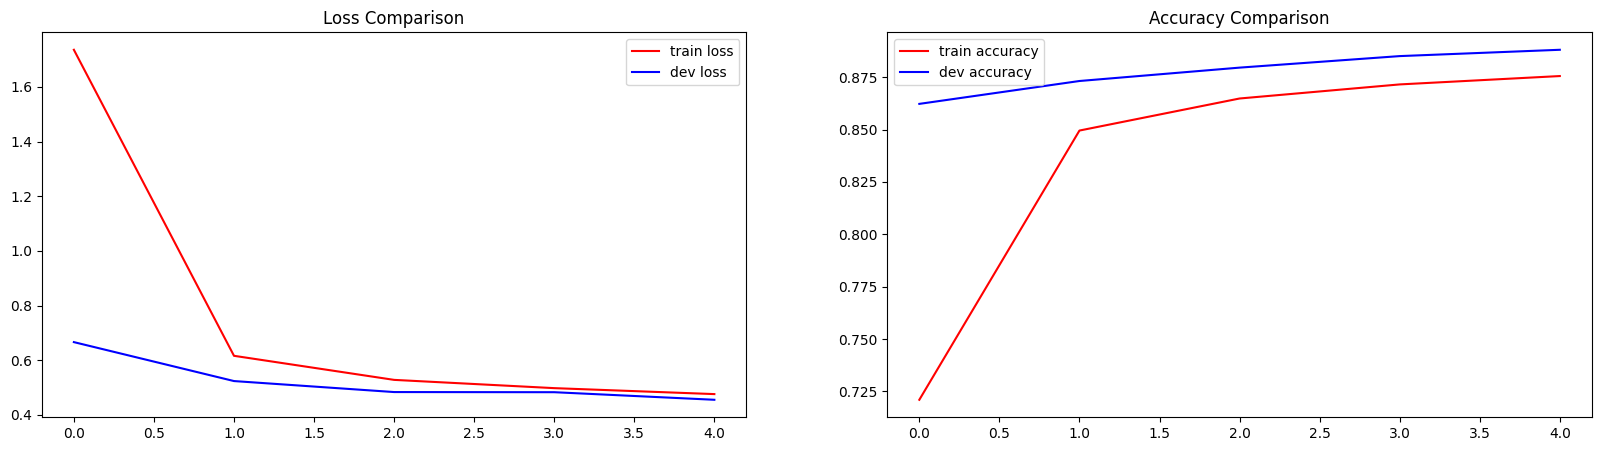

In [ ]:
# High Bias is a characteristic of an underfitted model and we would observe low accuracies for both train and validation set
# High Variance is a characterisitic of an overfitted model and we would observe high accuracy for train set and low for validation set
# To check for bias and variance plit the graphs for accuracy
# I have plotted for loss too, this helps in confirming if the loss is decreasing with each iteration - hence, the model is optimizing fine
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'dev loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_accuracy"], color='b', label = 'dev accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()

# RESULTS
# The train loss is consistently decreasing showing that Adam is able to optimize the model and find the minima
# The accuracy of train and validation is ~90% which is high enough, so low bias
# and the %s aren't that far apart, hence low variance

In [ ]:
show_history(results, True)

<a name='5.2'></a>
## 5.2 - View Predicted Segmentations

In [ ]:
unet.evaluate(X_valid, y_valid)

10/10 [==============================] - 71s 7s/step - loss: 0.4553 - accuracy: 0.8881


[0.4553372263908386, 0.88807213306427]

In [ ]:
# Results of Validation Dataset
def VisualizeResults(index):
    img = X_valid[index]
    img = img[np.newaxis, ...]
    pred_y = unet.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(X_valid[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(y_valid[index,:,:,0], cmap='gray')
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(pred_mask[:,:,0], cmap='gray')
    arr[2].set_title('Predicted Masked Image ')

In [ ]:
 # Results of Validation Dataset
def VisualizeResults1(index):
    img = X_valid[index]
    img = img[np.newaxis, ...]
    pred_y = unet.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]

    fig, axes = plt.subplots(1, 3, figsize=(5, 3))

    # Plot Image
    axes[0].imshow(X_valid[index])
    axes[0].set_title('Image')

    # Plot Mask
    axes[1].imshow(y_valid[index,:,:,0], cmap = 'gray')
    axes[1].set_title('Mask')

    # Plot Predicted
    axes[2].imshow(pred_mask[:,:,0], cmap = 'gray')
    axes[2].set_title('Predicted')

    plt.show()

1/1 [==============================] - 1s 587ms/step


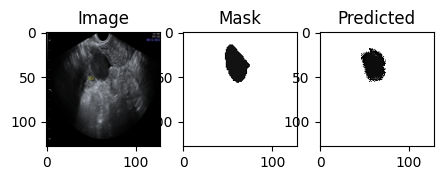

1/1 [==============================] - 0s 171ms/step


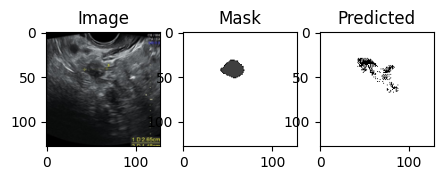

1/1 [==============================] - 0s 178ms/step


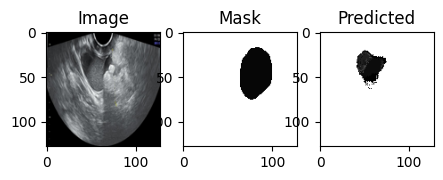

1/1 [==============================] - 0s 240ms/step


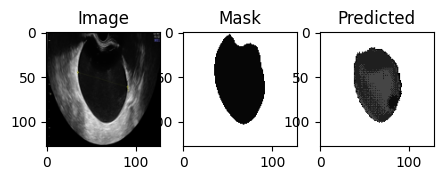

1/1 [==============================] - 0s 276ms/step


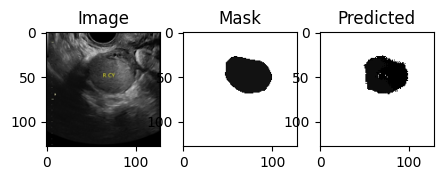

In [ ]:
# Add any index to contrast the predicted mask with actual mask
for index in range(0,5):
  VisualizeResults1(index)

# 6 - Classification

## 6.1 - Load data

In [ ]:
def load_images(path, num_images=50):

    images = []
    filenames = os.listdir(path)

    # Select a random subset of num_images from the list of filenames
    selected_filenames = np.random.choice(filenames, size=num_images, replace=False)

    for filename in tqdm(selected_filenames):
        image = cv2.imread(os.path.join(path, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)

    return np.array(images)

In [ ]:
# Specify the path to your data folder in Google Drive
dir_path = '/content/gdrive/MyDrive/Colab Notebooks/UTBT/OTU_2d_classes/'
# Check the contents of the folder
os.listdir(dir_path)

In [ ]:
classnames = ['Chocolate cyst', 'Serous cystadenoma', 'Teratoma', 'Normal ovary',
              'Theca cell tumor', 'Simple cyst', 'Mucinous cystadenoma', 'High grade serous']

class_0 = load_images(dir_path + classnames[0])
class_1 = load_images(dir_path + classnames[1])
class_2 = load_images(dir_path + classnames[2])
class_3 = load_images(dir_path + classnames[3])
class_4 = load_images(dir_path + classnames[4])
class_5 = load_images(dir_path + classnames[5])
class_6 = load_images(dir_path + classnames[6])
class_7 = load_images(dir_path + classnames[7])
classes = [class_0, class_1, class_2, class_3, class_4, class_5, class_6, class_7]

for class_images in classes:
    print(class_images.shape)

In [ ]:
#convert all image to gray scale image
def original(images):
  original_img = []
  for image in tqdm(images):
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        original_img.append(image)

  return np.array(original_img)

class_0_ori = original(class_0)
class_1_ori = original(class_1)
class_2_ori = original(class_2)
class_3_ori = original(class_3)
class_4_ori = original(class_4)
class_5_ori = original(class_5)
class_6_ori = original(class_6)
class_7_ori = original(class_7)

In [ ]:
#Original image
all_images_ori = np.vstack((class_0_ori, class_1_ori, class_2_ori, class_3_ori, class_4_ori,
                            class_5_ori, class_6_ori, class_7_ori))
all_images_ori.shape

## 6.2 - Apply Unet

In [ ]:
def roi_image(ori_images, seg_images):
    roi_images = []

    for ori_image, seg_image in tqdm(zip(ori_images, seg_images)):
        # Tìm contours trên ảnh đã phân đoạn
        contours, _ = cv2.findContours(seg_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Tạo một mask rỗng có cùng kích thước với ảnh gốc
        mask = np.zeros_like(ori_image)

        # Lặp qua từng contour để xác định vùng quan tâm (ROI) trên ảnh gốc
        for contour in contours:
            # Tính toán bounding box cho mỗi contour
            x, y, w, h = cv2.boundingRect(contour)

            # Vẽ bounding box lên mask
            cv2.rectangle(mask, (x, y), (x + w, y + h), (255, 255, 255), thickness=cv2.FILLED)

        # Áp dụng mask lên ảnh gốc để có được ROI
        roi_image = cv2.bitwise_and(ori_image, mask)

        # Thêm ảnh có ROI vào danh sách kết quả
        roi_images.append(roi_image)

    return roi_images

In [ ]:
def extract_lbp(images):
    lbps = []
    for image in tqdm(images):
        lbp = local_binary_pattern(image, P=8, R=2) #Using (8,2) LBP
        lbps.append(lbp)

    return np.array(lbps)

In [ ]:
def predata(images):
    trans_img = []
    for image in tqdm(images):
      img = img.resize((128, 128))  # Resize to match the input shape of the model
      img_array = np.array(img) / 255.0  # Normalize pixel values to the range [0, 1]
      img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

      trans_img.append(image)

    return np.array(trans_img)

In [ ]:
def apply_unet(images):
  unet_img = []
  for image in tqdm(images):
      pred = unet(image)

      unet_img.append(pred)

  return np.array(unet_img)

In [ ]:
#Original ROI
class_0_unet = predata(class_0)
class_1_unet = predata(class_1)
class_2_unet = predata(class_2)
class_3_unet = predata(class_3)
class_4_unet = predata(class_4)
class_5_unet = predata(class_5)
class_6_unet = predata(class_6)
class_7_unet = predata(class_7)

class_0_unet = apply_unet(class_0_unet)
class_1_unet = apply_unet(class_1_unet)
class_2_unet = apply_unet(class_2_unet)
class_3_unet = apply_unet(class_3_unet)
class_4_unet = apply_unet(class_4_unet)
class_5_unet = apply_unet(class_5_unet)
class_6_unet = apply_unet(class_6_unet)
class_7_unet = apply_unet(class_7_unet)
all_images_unet = np.vstack((class_0_ori, class_1_ori, class_2_ori, class_3_ori, class_4_ori,
                            class_5_ori, class_6_ori, class_7_ori))
all_images_unet.shape

In [ ]:
labels = np.array([0], [1], [2], [3], [4], [5], [6], [7])
labels[:100]

In [ ]:
X_train_ori, X_test_ori, y_train_ori, y_test_ori = train_test_split(all_images_ori,
                                                                    labels,
                                                                    test_size=0.2)

print('X_train_ori.shape\t', X_train_ori.shape)
print('X_test_ori.shape\t', X_test_ori.shape)
print('y_train_ori.shape\t', y_train_ori.shape)
print('y_test_ori.shape\t', y_test_ori.shape)

In [ ]:
X_train_ori_unet, X_test_ori_unet, y_train_ori_unet, y_test_ori_unet = train_test_split(all_images_unet,
                                                                                        labels,
                                                                                        test_size=0.2)

print('X_train_ori_unet.shape\t', X_train_ori_unet.shape)
print('X_test_ori_unet.shape\t', X_test_ori_unet.shape)
print('y_train_ori_unet.shape\t', y_train_ori_unet.shape)
print('y_test_ori_unet.shape\t', y_test_ori_unet.shape)

In [ ]:
X_train_lbp_ori = extract_lbp(X_train_ori)
X_test_lbp_ori = extract_lbp(X_test_ori)
X_train_lbp_ori_unet = extract_lbp(X_train_ori_unet)
X_test_lbp_ori_unet = extract_lbp(X_test_ori_unet)

In [ ]:
def create_histograms(images, sub_images_num, bins_per_sub_images):
    all_histograms = []
    for image in tqdm(images):
        rows, cols = 2, 2  # Number of rows and columns for dividing the image

        # Calculate the step size for rows and columns
        step_row = image.shape[0] // rows
        step_col = image.shape[1] // cols

        sub_image_histograms = []

        for i in range(rows):
            for j in range(cols):
                # Calculate the starting and ending indices for the current block
                start_row, end_row = i * step_row, (i + 1) * step_row
                start_col, end_col = j * step_col, (j + 1) * step_col

                sub_image = image[start_row:end_row, start_col:end_col]

                sub_image_histogram = np.histogram(sub_image, bins=bins_per_sub_images)[0]
                sub_image_histograms.append(sub_image_histogram)

        histogram = np.array(sub_image_histograms).flatten()
        all_histograms.append(histogram)

    return np.array(all_histograms)

In [ ]:
#Original
X_train_hist_ori = create_histograms(X_train_ori, sub_images_num=4, bins_per_sub_images=256)
X_test_hist_ori = create_histograms(X_test_ori, sub_images_num=4, bins_per_sub_images=256)

print('X_train_hist_ori\t', X_train_hist_ori.shape)
print('X_test_hist_ori\t', X_test_hist_ori.shape)

In [ ]:
#Original LBP
X_train_hist_ori_lbp = create_histograms(X_train_lbp_ori, sub_images_num=4, bins_per_sub_images=256)
X_test_hist_ori_lbp = create_histograms(X_test_lbp_ori, sub_images_num=4, bins_per_sub_images=256)

print('X_train_hist_ori_lbp\t', X_train_hist_ori_lbp.shape)
print('X_test_hist_ori_lbp\t', X_test_hist_ori_lbp.shape)

In [ ]:
#Original ROI
X_train_hist_ori_unet = create_histograms(X_train_ori_unet, sub_images_num=4, bins_per_sub_images=256)
X_test_hist_ori_unet = create_histograms(X_test_ori_unet, sub_images_num=4, bins_per_sub_images=256)

print('X_train_hist_ori after ROI\t', X_train_hist_ori.shape)
print('X_test_hist_ori after ROI\t', X_test_hist_ori.shape)

In [ ]:
#Original ROI LBP
X_train_hist_ori_unet_lbp = create_histograms(X_train_lbp_ori_unet, sub_images_num=4, bins_per_sub_images=256)
X_test_hist_ori_unet_lbp = create_histograms(X_test_lbp_ori_unet, sub_images_num=4, bins_per_sub_images=256)

print('X_train_hist_ori after ROI and LBP\t', X_train_hist_ori.shape)
print('X_test_hist_ori after ROI and LBP\t', X_test_hist_ori.shape)

## 6.3 - Classification

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn import metrics
from keras.callbacks import EarlyStopping

mpl.rcParams['figure.dpi'] = 150

font = {'family' : 'normal',
    'weight' : 'normal',
    'size'   : 8}
plt.rc('font', **font)

def train_model(classifier, X_train, X_test, y_train, y_test):
  %time classifier.fit(X_train, y_train)

  train_predictions = classifier.predict(X_train)
  test_predictions = classifier.predict(X_test)
  confusion_matrix = metrics.confusion_matrix(y_test, test_predictions)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
                                              display_labels =  ['Beni', 'Mali'])
  cm_display.plot()
  plt.xticks(rotation=90)
  plt.show()
  print(metrics.classification_report(y_test, test_predictions))

  print("Train accuracy: ", metrics.accuracy_score(train_predictions, y_train))
  print("Test accuracy: ", metrics.accuracy_score(test_predictions, y_test))

In [ ]:
train_model(SVC(), X_train_hist_ori, y_train_ori, X_test_hist_ori, y_test_ori)
train_model(SVC(), X_train_hist_ori_lbp, y_train_ori, X_test_hist_ori_lbp, y_test_ori)
train_model(SVC(), X_train_hist_ori_unet, y_train_ori_unet, X_test_hist_ori_unet, y_test_ori_unet)
train_model(SVC(), X_train_hist_ori_unet_lbp, y_train_ori_unet, X_test_hist_ori_unet_lbp, y_test_ori_unet)

In [ ]:
model_svm = SVC()
predictions = model_svm.predict(X_test_hist_ori)

In [ ]:
def find_misclassifications(labels, preds):
    indices = []
    for i, (label, pred) in enumerate(zip(preds, labels)):
        if pred != label:
            indices.append(i)

    return np.array(indices)

misclassifications = find_misclassifications(y_test_ori, predictions)
misclassifications

In [ ]:
def show_misclassifications(images, misclassified, labels, preds, start_index=0):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(6, 6))

    index = start_index
    for i in range(2):
        for j in range(2):
            axes[i,j].imshow(images[misclassified[index]], cmap='gray')
            axes[i,j].set_title(f'actual: {classnames[labels[misclassified[index]]]} \n' \
                                f'pred: {classnames[preds[misclassified[index]]]}')
            axes[i,j].get_xaxis().set_visible(False)
            axes[i,j].get_yaxis().set_visible(False)
            if index == (index+2):
                break
            index += 1
    plt.show()

show_misclassifications(X_test_ori, misclassifications, y_test_ori, predictions, start_index=3)

In [ ]:
diffusion model